# Amazon Bedrock Batch Inference

## 背景
- Bedrockのbatch推論のquotaがon demandと関係ない（だからquotaに引っ掛からなくてうれしい）と言う説
- text to image (SDXL or Titan or Both)で500枚くらいバッチ推論ジョブを発行してどんな風に実行が完了するか（もしくは完了しないか）を見てみる
- On demandのquotaより明らかに早かったら嬉しい


## 検証条件
- 推論方式: バッチ
- 生成: テキスト → 画像
- モデル:
    - amazon.titan-image-generator-v1
    - stability.stable-diffusion-xl-v1

## 結論

### 入出力データ
- インターフェイスはS3のみ。
- バッチ推論は入出力ファイルサイズ制限がある。モデル間での差分はない。
- https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- 最小も最大も定義されている。

#### 入力データフォーマット
- 一枚一枚に対してはオンデマンド推論と同じ。それをJSONLにしてS3に置く。
- リクエスト枚数が少ないと、ジョブ実行時の序盤にエラーで跳ね返される。
    - Titan: 4枚
    - SD: 10枚

#### 出力データフォーマット
それぞれのモデルで出力方法が全く異なるので注意

- Titan：単一のJSONLにバイナリで全画像が入力情報とセットで埋まっている。大量画像入っているのでデカJSONL
- SD：ファイル名に連番が入った一枚一枚のPNG

入力と出力の突き合わせ

- Titan：1行ずつの入力と出力がすぐ対応できるので、突き合わせしやすい
- SD：連番で突き合わせ作業するしかない

### ジョブ
- ジョブは並列実行されない。
- 複数のジョブを投げることは可能だが、順序保証されて（Undocumented）キューイングされて順次処理される。したがって前のジョブが完了するまで次のジョブは実行されない。
- よってジョブの並列実行による高速化はされない。
- またバッチ推論にすることでオンラインより高速化もされない。
- バッチ推論ジョブの速度はオンデマンド推論を同期処理しているような速度のため、非同期でオンデマンド処理させた方が高速化は可能。

### 結果
600枚全て成功

- Titan: 12 sec / image
- SD: 7 sec /image　← 70分くらい

条件全て揃えられているわけではないので注意

## 公開情報
- 開発者ドキュメント: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html
- Quota: https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- コードサンプル: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

## 環境準備

### 2024.2.1
- Public Preview
- 利用方法
    - REST API: あると思うが面倒
    - CLI: 無さそう
    - SDK: プレビューのがある
        - PythonとJavaのみ
        - ただし他サービスと同様、プレビュー状態のAPIは一般公開SDKに含まれていない
        - そのため以下の公式whlからインストールが必要
        - https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
    - コンソール: 無さそう

Python SDKを使うこととし、以下でSDKのインストールをする

In [12]:
! chmod +x install_sdk.sh
! ./install_sdk.sh

--2024-02-08 06:01:01--  https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
Resolving d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)... 108.138.82.216, 108.138.82.207, 108.138.82.42, ...
Connecting to d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)|108.138.82.216|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 314169135 (300M) [application/zip]
Saving to: ‘sdk.zip’

sdk.zip             100%[===================>] 299.61M  53.5MB/s    in 5.9s    

2024-02-08 06:01:07 (51.1 MB/s) - ‘sdk.zip’ saved [314169135/314169135]

Archive:  sdk.zip
sdk/botocore-1.32.4-py3-none-any.whl
sdk/boto3-1.29.4-py3-none-any.whl
Processing ./sdk/botocore-1.32.4-py3-none-any.whl
botocore is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing ./sdk/boto3-1.29.4-py3-none-any.whl
boto3 is alr

上記実行後、カーネルの再起動が必要

In [14]:
from IPython import Application
Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 

```aws s3 cp``` などをするため、AWS CLIがあるか確認

In [ ]:
! aws --version

aws-cli/2.15.0 Python/3.11.6 Linux/4.14.336-253.554.amzn2.x86_64 exe/x86_64.ubuntu.22 prompt/off


## 入力データフォーマット

参考: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-data.html

以下、サンプルの入力JSON

入力JSON Linesフォーマット
```JSON
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
...
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {JSON body}
}
```

Titan imageの場合の推論入力JSON: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-image-api


```JSON
{
    "inputText": string,
    "textGenerationConfig": {
        "temperature": float,  
        "topP": float,
        "maxTokenCount": int,
        "stopSequences": [string]
    }
}
```

Tiatanの場合のバッチ推論入力JSON Lines
```JSON
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": {
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
...
{
    "recordId": "12 character alphanumeric string",
    "modelInput": {
        "inputText": string,
        "textGenerationConfig": {
            "temperature": float,  
            "topP": float,
            "maxTokenCount": int,
            "stopSequences": [string]
        }
    }
}
```

## 共通条件設定

In [1]:
image_size:int = 1024
cfg_scale:int = 8.0
seed:int = 0

In [2]:
height:int = image_size
width:int = image_size

image_generation_config:dict = {
    "numberOfImages": 1,
    "quality": "standard",
    "height": height,
    "width": width,
    "cfgScale": cfg_scale,
    "seed": seed
}

## 単発推論
まずは単発を確認

In [3]:
prompt:str = "A dog running at a park."

from func import generate_image_by

### Titan image
https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html

INFO:func:Generating image with amazon.titan-image-generator-v1 model.
INFO:func:Successfully generated image with amazon.titan-image-generator-v1 model.


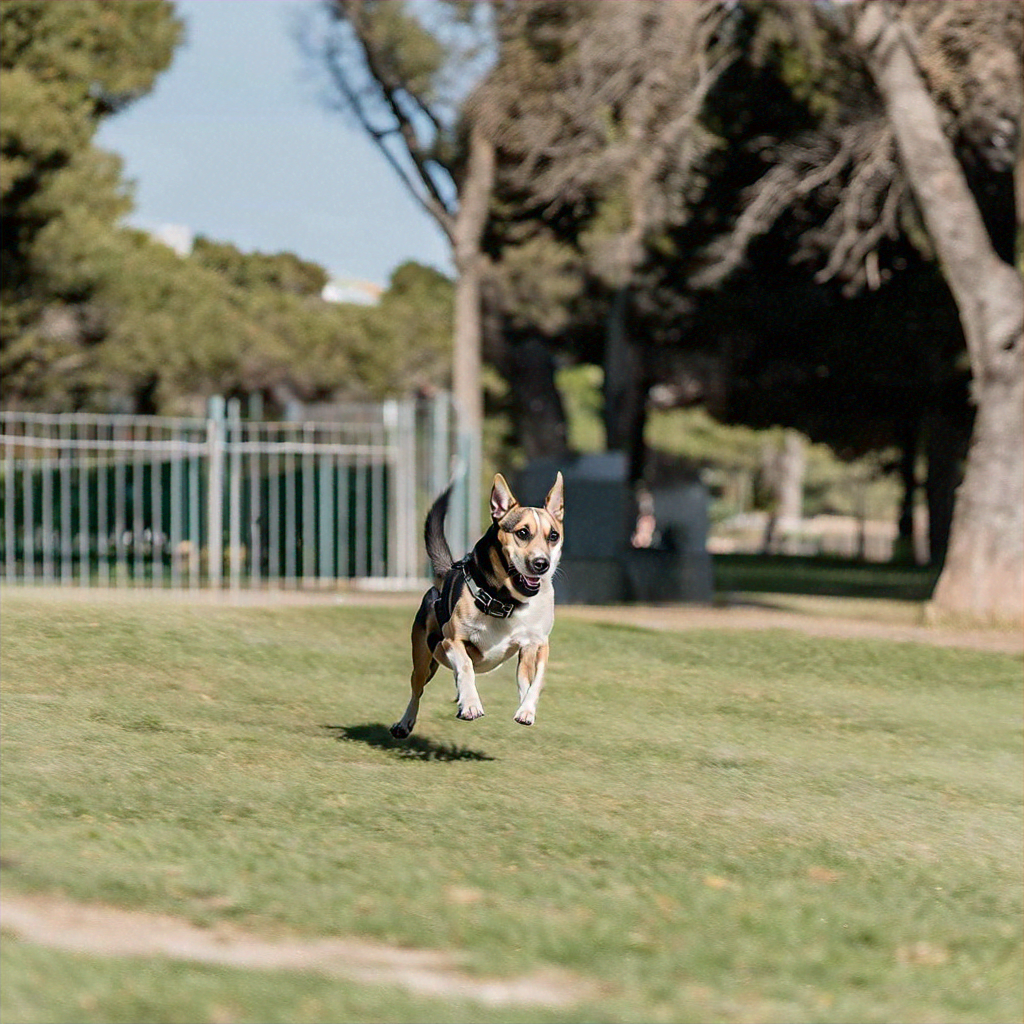

Finished generating image with amazon.titan-image-generator-v1 model.


In [4]:
body = {
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt
    },
    "imageGenerationConfig": image_generation_config
}
generate_image_by(model_id="amazon.titan-image-generator-v1", body=body)

### Stable Diffusion
https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-text-image.html

INFO:func:Generating image with stability.stable-diffusion-xl-v1 model.
INFO:func:Successfully generated image with stability.stable-diffusion-xl-v1 model.


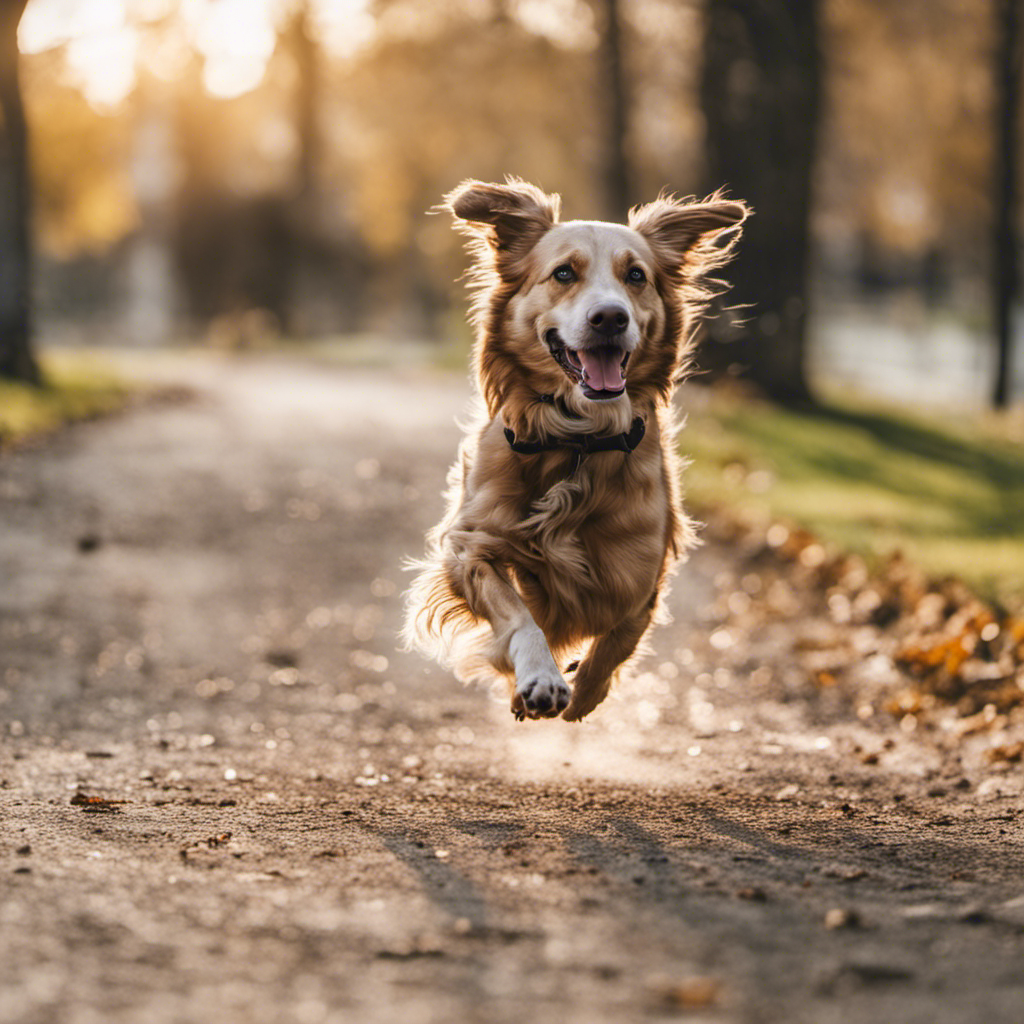

Finished generating image with stability.stable-diffusion-xl-v1 model.


In [5]:
body = {
    "text_prompts": [{"text": prompt}],
    "height": height,
    "width": width,
    "cfg_scale": cfg_scale,
    # "clip_guidance_preset": string,
    # "sampler": string,
    # "samples",
    "seed": seed,
    # "steps": int,
    # "style_preset": string,
    # "extras" :JSON object
}
generate_image_by(model_id="stability.stable-diffusion-xl-v1", body=body)

## 検証

### 条件設定

バッチ推論は入出力ファイルサイズ制限がある。モデル間での差分はない。
https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch

最小も最大も定義されている。そのためリクエスト枚数が少ないと、ジョブ実行時の序盤にエラーで跳ね返される。

- Titan: 4枚
- SD: 10枚

程度が最小。

In [3]:
model_id:str = "amazon.titan-image-generator-v1"
number_of_images:int = 10

In [5]:
model_id:str = "stability.stable-diffusion-xl-v1"
number_of_images:int = 10

### バッチ用入力データ出力

In [4]:
import json

prompts = [f"{i+2} dogs running at a park." for i in range(number_of_images)]
_requests:list = list()

if "titan" in model_id:
    for _record_id, _prompt in enumerate(prompts):
        _body:dict = {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": _prompt
            },
            "imageGenerationConfig": image_generation_config
        }
        _record:dict = {
            "recordId": str(_record_id).zfill(12),
            "modelInput": _body
        }
        _requests.append(json.dumps(_record))
elif "stable" in model_id:
    for _record_id, _prompt in enumerate(prompts):
        _body:dict = {
            "text_prompts": [{"text": _prompt}],
            "height": height,
            "width": width,
            "cfg_scale": cfg_scale,
            # "clip_guidance_preset": string,
            # "sampler": string,
            # "samples",
            "seed": seed,
            # "steps": int,
            # "style_preset": string,
            # "extras" :JSON object
        }
        _record:dict = {
            "recordId": str(_record_id).zfill(12),
            "modelInput": _body
        }
        _requests.append(json.dumps(_record))

jsonl = "\n".join(_requests)

from pprint import pprint
pprint(jsonl)

('{"recordId": "000000000000", "modelInput": {"taskType": "TEXT_IMAGE", '
 '"textToImageParams": {"text": "2 dogs running at a park."}, '
 '"imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", '
 '"height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}\n'
 '{"recordId": "000000000001", "modelInput": {"taskType": "TEXT_IMAGE", '
 '"textToImageParams": {"text": "3 dogs running at a park."}, '
 '"imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", '
 '"height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}\n'
 '{"recordId": "000000000002", "modelInput": {"taskType": "TEXT_IMAGE", '
 '"textToImageParams": {"text": "4 dogs running at a park."}, '
 '"imageGenerationConfig": {"numberOfImages": 1, "quality": "standard", '
 '"height": 1024, "width": 1024, "cfgScale": 8.0, "seed": 0}}}\n'
 '{"recordId": "000000000003", "modelInput": {"taskType": "TEXT_IMAGE", '
 '"textToImageParams": {"text": "5 dogs running at a park."}, '
 '"imageGenerationConfig": {

In [5]:
import bedrock
batch = bedrock.Batch(
    model_id = "amazon.titan-image-generator-v1",
    number_of_images = 10,
    inputs = jsonl,
    region = "us-east-1",
)

In [36]:
from utils import get_formatted_time
condition:str = f"{model_id}/{number_of_images}"
job_name:str = f"{condition}/{get_formatted_time()}"
job_name = job_name.replace("/", "-")
print(job_name)

dir = f"Bedrock/Batch-Inference/{condition}"
jsonl_key = f"{dir}/input.jsonl"

from boto3 import resource
s3 = resource('s3')
bucket = s3.Bucket(bucket_name)
jsonl_obj = bucket.Object(key=jsonl_key)
jsonl_obj.put(Body=jsonl)

stability.stable-diffusion-xl-v1-10-20240208-131035


{'ResponseMetadata': {'RequestId': 'MRG5V61V0759AVXS',
  'HostId': 'HJzYuHIqVtNJUIrRtcW1dDYYWK9gSFzEmE2N39Ftl/n4JOl58daKCtoMV3B5+gGWmxGFioS3TtCKe4FMR8htb0TxzYlZUDQx',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HJzYuHIqVtNJUIrRtcW1dDYYWK9gSFzEmE2N39Ftl/n4JOl58daKCtoMV3B5+gGWmxGFioS3TtCKe4FMR8htb0TxzYlZUDQx',
   'x-amz-request-id': 'MRG5V61V0759AVXS',
   'date': 'Thu, 08 Feb 2024 04:10:36 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"6653a041f01752a3b1fe71cf197cbf58"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"6653a041f01752a3b1fe71cf197cbf58"',
 'ServerSideEncryption': 'AES256'}

ここで、

- S3に入力ファイルがアップロードされたか
- アップロードされたファイルの中身が正しいか

を確認するため、S3内のファイルの中身を覗く

In [37]:
! aws s3 cp s3://$bucket_name/$jsonl_key -

{"recordId": "000000000000", "modelInput": {"text_prompts": [{"text": "2 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000001", "modelInput": {"text_prompts": [{"text": "3 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000002", "modelInput": {"text_prompts": [{"text": "4 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000003", "modelInput": {"text_prompts": [{"text": "5 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000004", "modelInput": {"text_prompts": [{"text": "6 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000005", "modelInput": {"text_prompts": [{"text": "7 dogs running at a park."}], "height": 1024, "width": 1024, "cfg_scale": 8.0, "seed": 0}}
{"recordId": "000000000006",

### 推論

ジョブの状態はこちら: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-list.html

ジョブは並列実行されない。

複数のジョブを投げることは可能だが、ジョブが順序保証されて（Undocumented）キューイングされて順次処理される。したがって前のジョブが完了するまで次のジョブは実行されない。

よってジョブの並列実行による高速化はされない。

またバッチ推論にすることでオンラインより高速化もされない。

バッチ推論ジョブの速度はオンデマンド推論を同期処理しているような速度のため、非同期でオンデマンド処理させた方が高速化は可能。

In [38]:
from time import perf_counter, sleep
from boto3 import client
bedrock = client(service_name="bedrock", region_name=region)


def get_job_status_of(job_arn:str) -> str:
    job:dict = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
    job_status:str = job.get("status")
    sleep(1)
    return job_status


def wait(job_arn:str, monitored_status:str) -> str:
    job_status:str = monitored_status
    print(job_status)

    started_time = perf_counter()
    while job_status == monitored_status:
        job_status:str = get_job_status_of(job_arn)
    ended_time = perf_counter()

    time_delta = round(ended_time - started_time)
    print(f" | {time_delta} sec")
    return job_status


def wait_until_complete(job_arn:str):
    print("----- Job status -----")
    job_status:str = wait(job_arn=job_arn, monitored_status="Submitted")
    job_status:str = wait(job_arn=job_arn, monitored_status=job_status)
    print(job_status)

    error_message:str = bedrock.get_model_invocation_job(jobIdentifier=job_arn).get("message")
    print(error_message)
    ! aws s3 cp $output_dir$job_id/manifest.json.out -

In [39]:
%%time

inputDataConfig = ({
    "s3InputDataConfig": {
        "s3Uri": f"s3://{bucket_name}/{jsonl_key}"
    }
})

output_dir:str = f"s3://{bucket_name}/{dir}/"
outputDataConfig=({
    "s3OutputDataConfig": {
        "s3Uri": output_dir
    }
})

response = bedrock.create_model_invocation_job(
    roleArn = role,
    modelId = model_id,
    jobName = job_name,
    inputDataConfig = inputDataConfig,
    outputDataConfig = outputDataConfig
)
from pprint import pprint
pprint(response, width=30, compact=False)

job_arn = response.get("jobArn")
job_id = job_arn.split("/")[-1].strip()
print(job_id)

wait_until_complete(job_arn)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '85',
                                      'content-type': 'application/json',
                                      'date': 'Thu, '
                                              '08 '
                                              'Feb '
                                              '2024 '
                                              '04:10:40 '
                                              'GMT',
                                      'x-amzn-requestid': 'ef4878c6-79d9-46f9-b339-8ad86fc7bc1b'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'ef4878c6-79d9-46f9-b339-8ad86fc7bc1b',
                      'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:624045005200:model-invocation-job/vz78mpl5hdw0'}
vz78mpl5hdw0
----- Job status -----
Submitted


 | 13 sec
InProgress
 | 227 sec
Completed
None
{"processedRecordCount":10,"successRecordCount":10,"errorRecordCount":0,"outputImgCount1024x1024pStep50":10,"outputImgCount1024x1024pStep150":0}
CPU times: user 759 ms, sys: 46.6 ms, total: 806 ms
Wall time: 4min 1s


In [41]:
job_info:dict = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
print(job_info)
progress_time = job_info.get("lastModifiedTime") - job_info.get("submitTime")

print(f"{job_info.get('status')} - {progress_time}")
print(job_info.get("message"))

{'ResponseMetadata': {'RequestId': 'd750f88d-83f0-468f-8731-15c7e935351d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 08 Feb 2024 04:19:16 GMT', 'content-type': 'application/json', 'content-length': '720', 'connection': 'keep-alive', 'x-amzn-requestid': 'd750f88d-83f0-468f-8731-15c7e935351d'}, 'RetryAttempts': 0}, 'jobArn': 'arn:aws:bedrock:us-east-1:624045005200:model-invocation-job/vz78mpl5hdw0', 'jobName': 'stability.stable-diffusion-xl-v1-10-20240208-131035', 'modelId': 'arn:aws:bedrock:us-east-1::foundation-model/stability.stable-diffusion-xl-v1:0', 'status': 'Completed', 'submitTime': datetime.datetime(2024, 2, 8, 4, 10, 40, 921000, tzinfo=tzlocal()), 'lastModifiedTime': datetime.datetime(2024, 2, 8, 4, 14, 39, 438000, tzinfo=tzlocal()), 'inputDataConfig': {'s3InputDataConfig': {'s3Uri': 's3://service-default/Bedrock/Batch-Inference/stability.stable-diffusion-xl-v1/10/input.jsonl'}}, 'outputDataConfig': {'s3OutputDataConfig': {'s3Uri': 's3://service-default/Bedrock/Batc

以下のファイル内容表示は、画像のバイナリのためたった数枚でもエディタが重くなるデータサイズなので注意

In [ ]:
# ! aws s3 cp $output_dir$job_id/input.jsonl.out -

### 画像表示
それぞれのモデルで出力方法が全く異なるので注意

- Titan：単一のJSONLにbase64で全画像が入力情報とセットで埋まっている
- SD：ファイル名に連番が入った一枚一枚のPNG

入力と出力の突き合わせ

- Titan：1行ずつの入力と出力がすぐ対応できるので、突き合わせしやすい
- SD：連番で突き合わせ作業するしかない

In [20]:
import base64
from io import BytesIO
from PIL import Image

output_dir:str = f"{dir}/{job_id}"

def get_content_binary(key:str):
    output_obj = bucket.Object(key=output_key).get()
    binary_contents = output_obj.get("Body").read()
    return binary_contents


def display_image(image_bytes):
    image = Image.open(BytesIO(image_bytes))
    image.show()

Bedrock/Batch-Inference/output/6rjp4wyz6zsh/stability.stable-diffusion-xl-v1.000000000000.1.png


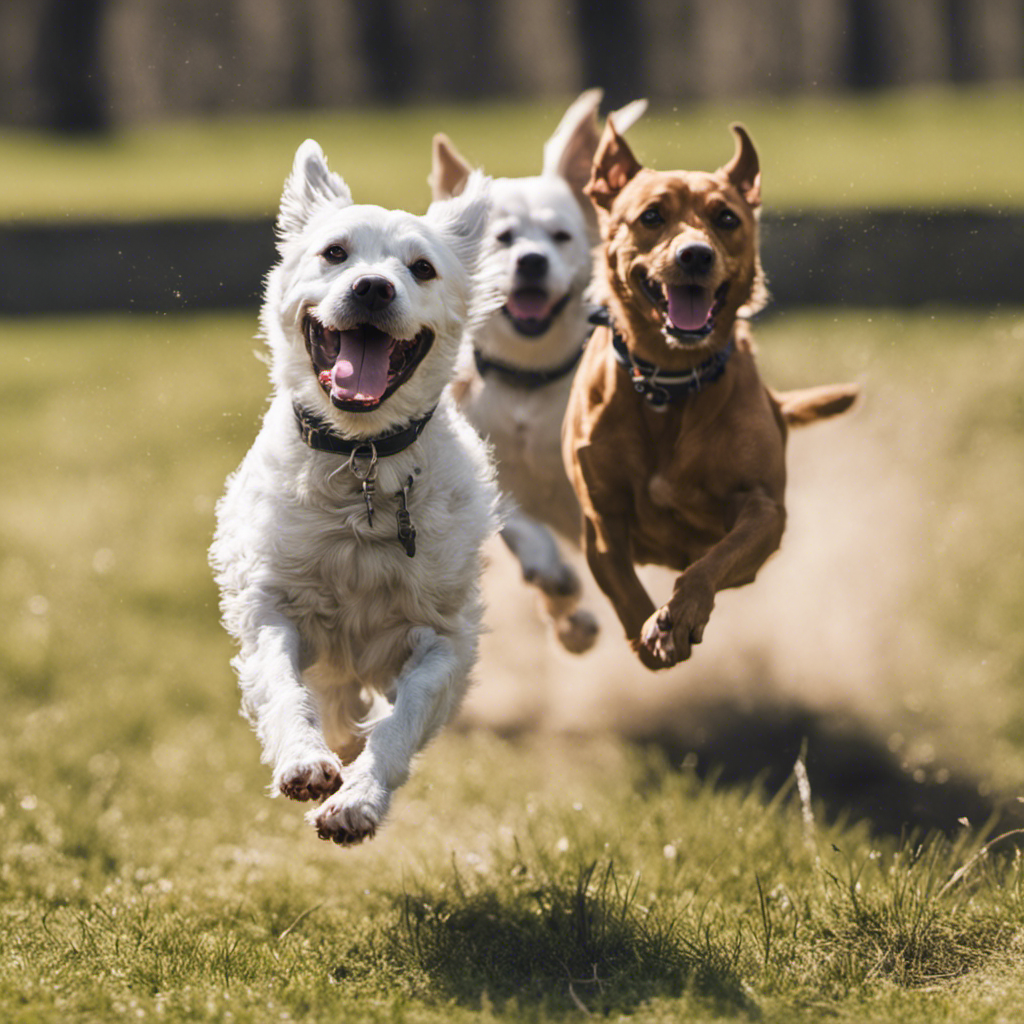

Bedrock/Batch-Inference/output/6rjp4wyz6zsh/stability.stable-diffusion-xl-v1.000000000001.1.png


In [21]:
import json

if "titan" in model_id:
    output_key = f"{output_dir}/{model_id}.jsonl.out"
    binary_contents = get_content_binary(output_key)

    for line in BytesIO(binary_contents):
        content = json.loads(line.decode("utf-8"))
        # finish_reason = content.get("error")
        # if finish_reason is not None: print(f"Image generation error. Error is {finish_reason}")
        print(content.get("modelInput").get("textToImageParams").get("text"))
        base64_image = content.get("modelOutput").get("images")[0]
        base64_bytes = base64_image.encode('ascii')
        image_bytes = base64.b64decode(base64_bytes)
        display_image(image_bytes)
elif "stable" in model_id:
    for record_id in range(number_of_images):
        output_key = f"{output_dir}/{model_id}.{str(record_id).zfill(12)}.1.png"
        binary_contents = get_content_binary(output_key)
        print(output_key)
        display_image(binary_contents)

In [18]:
# jobs = bedrock.list_model_invocation_jobs().get("invocationJobSummaries")
# from pprint import pprint
# # pprint(jobs)
# for job in jobs:
#     # a = f"{job.get("jobArn")}"
#     print(job)

## 結論

### 入出力データ
- インターフェイスはS3のみ。
- バッチ推論は入出力ファイルサイズ制限がある。モデル間での差分はない。
- https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- 最小も最大も定義されている。

#### 入力データフォーマット
- 一枚一枚に対してはオンデマンド推論と同じ。それをJSONLにしてS3に置く。
- リクエスト枚数が少ないと、ジョブ実行時の序盤にエラーで跳ね返される。
    - Titan: 4枚
    - SD: 10枚

#### 出力データフォーマット
それぞれのモデルで出力方法が全く異なるので注意

- Titan：単一のJSONLにバイナリで全画像が入力情報とセットで埋まっている。大量画像入っているのでデカJSONL
- SD：ファイル名に連番が入った一枚一枚のPNG

入力と出力の突き合わせ

- Titan：1行ずつの入力と出力がすぐ対応できるので、突き合わせしやすい
- SD：連番で突き合わせ作業するしかない

### ジョブ
- ジョブは並列実行されない。
- 複数のジョブを投げることは可能だが、順序保証されて（Undocumented）キューイングされて順次処理される。したがって前のジョブが完了するまで次のジョブは実行されない。
- よってジョブの並列実行による高速化はされない。
- またバッチ推論にすることでオンラインより高速化もされない。
- バッチ推論ジョブの速度はオンデマンド推論を同期処理しているような速度のため、非同期でオンデマンド処理させた方が高速化は可能。

### 結果
600枚全て成功

- Titan: 12 sec / image
- SD: 7 sec /image　← 70分くらい

条件全て揃えられているわけではないので注意